### **For this assignment the only permitted libraries to use are Numpy, Scipy, MatplotLib and Pandas! All four have been imported for you in this Notebook.**

In [182]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data loading

Train and Test sets can be found in the `Resources` folder. You can choose to visualize your data all at once, in windows, or only considering a subset of sensors to detect which ones would prove most useful to your analysis.
An example of such a visualization can be found in the following cell.

### Familiarization 

1. There are multiple signal types visible in the training data. The first signal type shows, high signal strength (between 500 and 1000), cyclic behaviour and has a high variance, a good example is FIT201. The second type is one that shows very low signal strength(between 0 and 1), and low variance, A good example would be P402. the third type is medium signal strength (between 300 and 400), a good example would be AIT203.

2. Some of the signals seem to be correlated. LIT401 and LIT101 show some negative correlation in the sense that LIT101 increases while LIT401 decreases. This is also a form of cyclic behaviour as LIT401 constantly decreases and increases while LIT101 constantly increases and then decreases.  

In [183]:
train_file_path = 'lab1_train.csv'
test_file_path = 'lab1_test.csv'
train_data = pd.read_csv(train_file_path, delimiter=',')
test_data = pd.read_csv(test_file_path, delimiter=',')
# Convert Timestamp column to datetime
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')

In [184]:
def normalize_data(df):
    return (df - df.mean())

sensor_columns_train = train_data.columns[1:-1]
sensor_columns_test = test_data.columns[1:-1]

normalized_train_data = normalize_data(train_data[sensor_columns_train])
normalized_test_data = normalize_data(test_data[sensor_columns_test])

### Dynamic Time Warping

Dynamic time warping implementation. The dynamic_time_warping implementation creates a matrix that is 1 bigger than the two signals that are being compared in both the x and y axis. The matrix is filled with the euclidean distance between the two signals at each point. the matrix is then filled with the cost of the currently compared data point plus the minimum of the costs in [DTW[i-1, j ], DTW[i  , j-1],DTW[i-1, j-1]]. The last point in the matrix is the distance between the two signals. The distance between the two signals is then returned.

In terms of the types of anomolies we expect to find, it depends on the window size we choose for sliding windows. If we choose a small window size, we will find contextual anomolies, while if we choose a large window size, we will find collective anomolies.

In [185]:
def dynamic_time_warping(a, b):

    n = a.size
    m = b.size
    DTW = np.zeros(shape=(n +1 , m+1))

    for i in range(0, n+1):
        for j in range(0, m+1):
            DTW[i, j] = np.inf
    DTW[0,0] = 0

    for i in range(1, n +1):
        for j in range(1, m+1):
            cost = (a[i -1] - b[j-1])**2
            DTW[i, j] = cost + np.min([DTW[i-1, j ],    
                                        DTW[i  , j-1],   
                                        DTW[i-1, j-1]])  
    i = n
    j = m
    dist = DTW[i,j]
    return np.sqrt(dist)

Two functions to visualize the data

In [186]:
def visualize_sensor_data(df, window=None, sensors=None, skip =1):
    # If window is None, visualize the entire dataset
    if window is None:
        start_index, end_index = 0, len(df)
    else:
        start_index, end_index = window
    
    # If sensors is None, select all sensor columns
    if sensors is None:
        sensors = df.columns[1:-1]
    # Plot each sensor in a different color
    plt.figure(figsize=(15, 8))
    #print(len(df))
    for sensor in sensors:
        plt.plot(df['Timestamp'][start_index:end_index].iloc[::skip], df[sensor][start_index:end_index].iloc[::skip], label=sensor)

    plt.xlabel('Timestamp')
    plt.ylabel('Sensor Values')
    plt.title('Sensor Data Visualization')
    plt.legend()

    plt.show()
def visualize_sensor_data2(data, window, sensors, ax):
    start, end = window
    subset = data[sensors][start:end]
    for sensor in sensors:
        ax.plot(subset.index, subset[sensor], label=sensor)
    ax.set_title(f"Data from {start} to {end}")
    ax.set_xlabel("Data Point")
    ax.set_ylabel("Sensor Reading")
    ax.legend()
    ax.grid(True)

#fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns

# Plot training data on the first subplot
#visualize_sensor_data2(train_data, window=(200, 800), sensors=['FIT301'], ax=axes[0])
#axes[0].set_title("Train Data")

# Plot test data on the second subplot
#visualize_sensor_data2(test_data, window=(0, 1000), sensors=['FIT101', 'LIT101'], ax=axes[1])
#axes[1].set_title("Test Data")

#plt.tight_layout()
#plt.show()

Function to visualize the distance (residual). 

In [201]:
def compute_residuals(df, window=None, sensors=None, sliding_window_size = 0, treshold = 0, jump_size = 0, frac = 1, skip = 1):
    # If window is None, visualize the entire dataset
    if window is None:
        start_index, end_index = 0, len(df)
    else:
        start_index, end_index = window
    
    # If sensors is None, select all sensor columns
    if sensors is None:
        sensors = df.columns[1:-1]
    
   # df_subsampled = df.sample(frac=frac, random_state=42)
    
    # Plot each sensor in a different color
    #plt.figure(figsize=(15, 8))
    for sensor in sensors:
        #plt.plot(df['Timestamp'][start_index:end_index], df[sensor][start_index:end_index], label=sensor)
        distances = []
        anomolies = []
        sliding_windows = np.lib.stride_tricks.sliding_window_view(df[sensor][start_index:end_index].iloc[::skip], sliding_window_size)
        for i in range(len(sliding_windows) - sliding_window_size):
            distance = dynamic_time_warping(sliding_windows[start_index + i], sliding_windows[start_index +i+sliding_window_size])
            distances.append(distance)
            if (distance >= treshold):
                anomolies.append(distance)
            #increase i by jump size, also known as stride
            i += jump_size
            
        return distances

Here we visualize the distances (residuals). To improve performance we've decided to sample the data by taking every 1000th data point as which is what the "skip" variable is for. taking this as our sample still maintains the overall shape of the original graph. through the residual graph we can detect the anamoly as it shows a very high peak around that time, for this reason we set our treshhold to 30 to detect the anamoly.

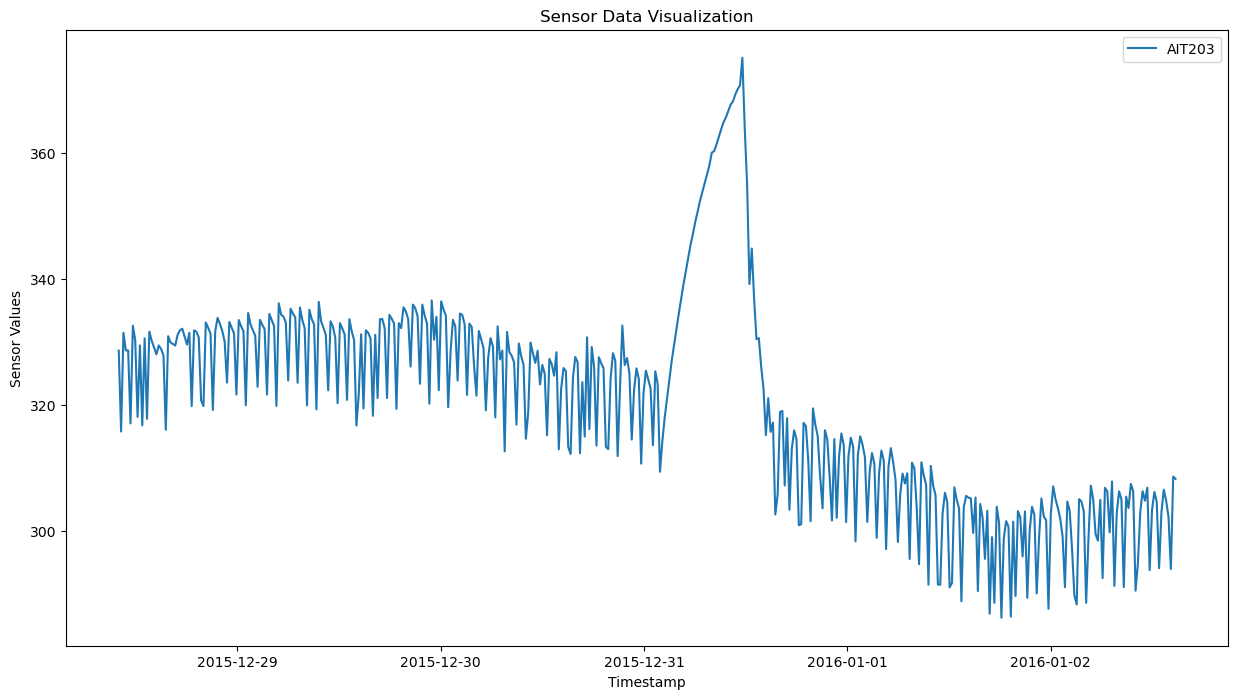

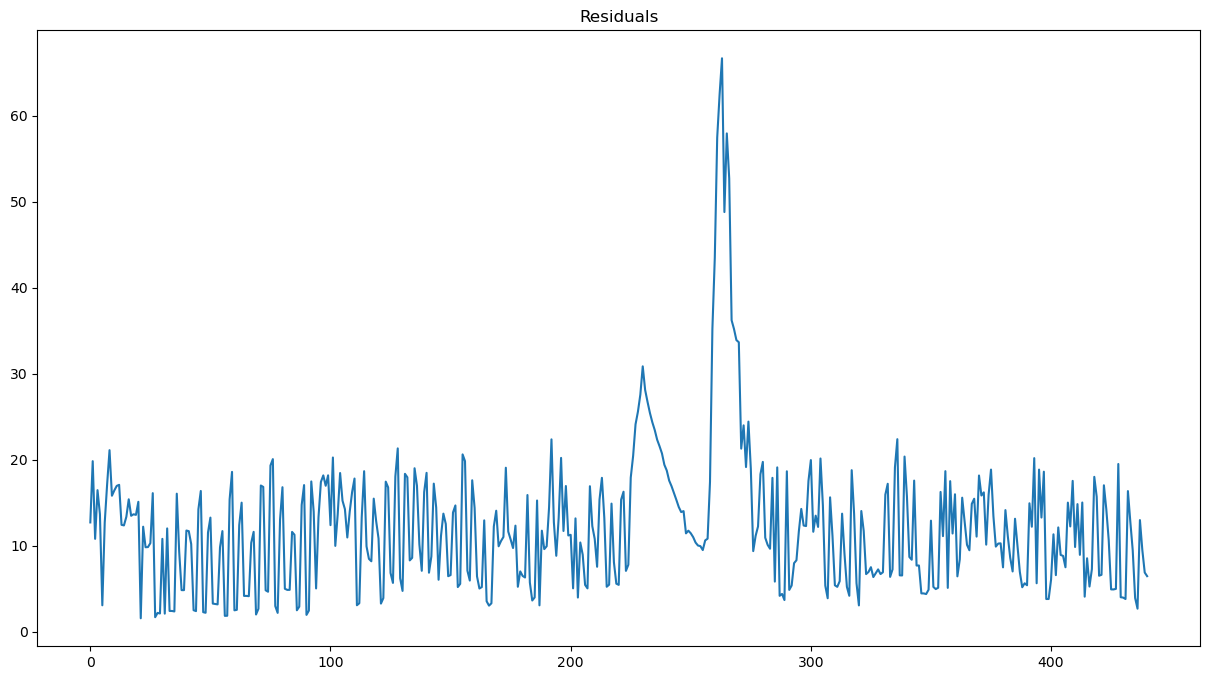

In [202]:
def visualize_distance(df,timestamps =None, window=None, sensors=None, sliding_window_size = 0, treshold = 0, jump_size = 0, skip = 1):
    # If window is None, visualize the entire dataset
    if window is None:
        start_index, end_index = 0, len(df)
    else:
        start_index, end_index = window
    
    # If sensors is None, select all sensor columns
    if sensors is None:
        sensors = df.columns[1:-1]
    
   # df_subsampled = df.sample(frac=frac, random_state=42)
    residuals = compute_residuals(df.iloc[::1000], window, sensors, sliding_window_size, treshold, jump_size, skip)
    # Plot each sensor in a different color
    plt.figure(figsize=(15, 8))
    plt.title('Residuals')
    plt.plot( residuals)  

    plt.show() 

    #plt.xlabel('Timestamp')
    #plt.ylabel('Sensor Values')
    #plt.title('Sensor Data Visualization')
    #plt.legend()

       

visualize_sensor_data(test_data, window=(0, 500000), sensors=['AIT203'], skip=1000)
visualize_distance(test_data, window=(0, 500000),  sensors=['AIT203'], sliding_window_size =5, jump_size=0, skip = 1000)
